In [21]:
#imports
import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import math
from typing import List, Tuple

## converting image.mat to numpy

In [22]:
# Load the MATLAB file
mat = scipy.io.loadmat('image_xyt.mat')

In [23]:
image=mat['image_xyt']

In [24]:
image.shape

(200, 256, 256)

### view fews sample frames

In [25]:
#function to display random images
def display_random_images(image: np.array,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(image.shape[-1]), k=n)

    # 5. Setup plot
    plt.figure(figsize=(60, 60))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image = image[:,:,targ_sample]
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image,cmap='gray')
        plt.axis("off")
        plt.title(f'Frame No:{targ_sample}',fontsize=25)

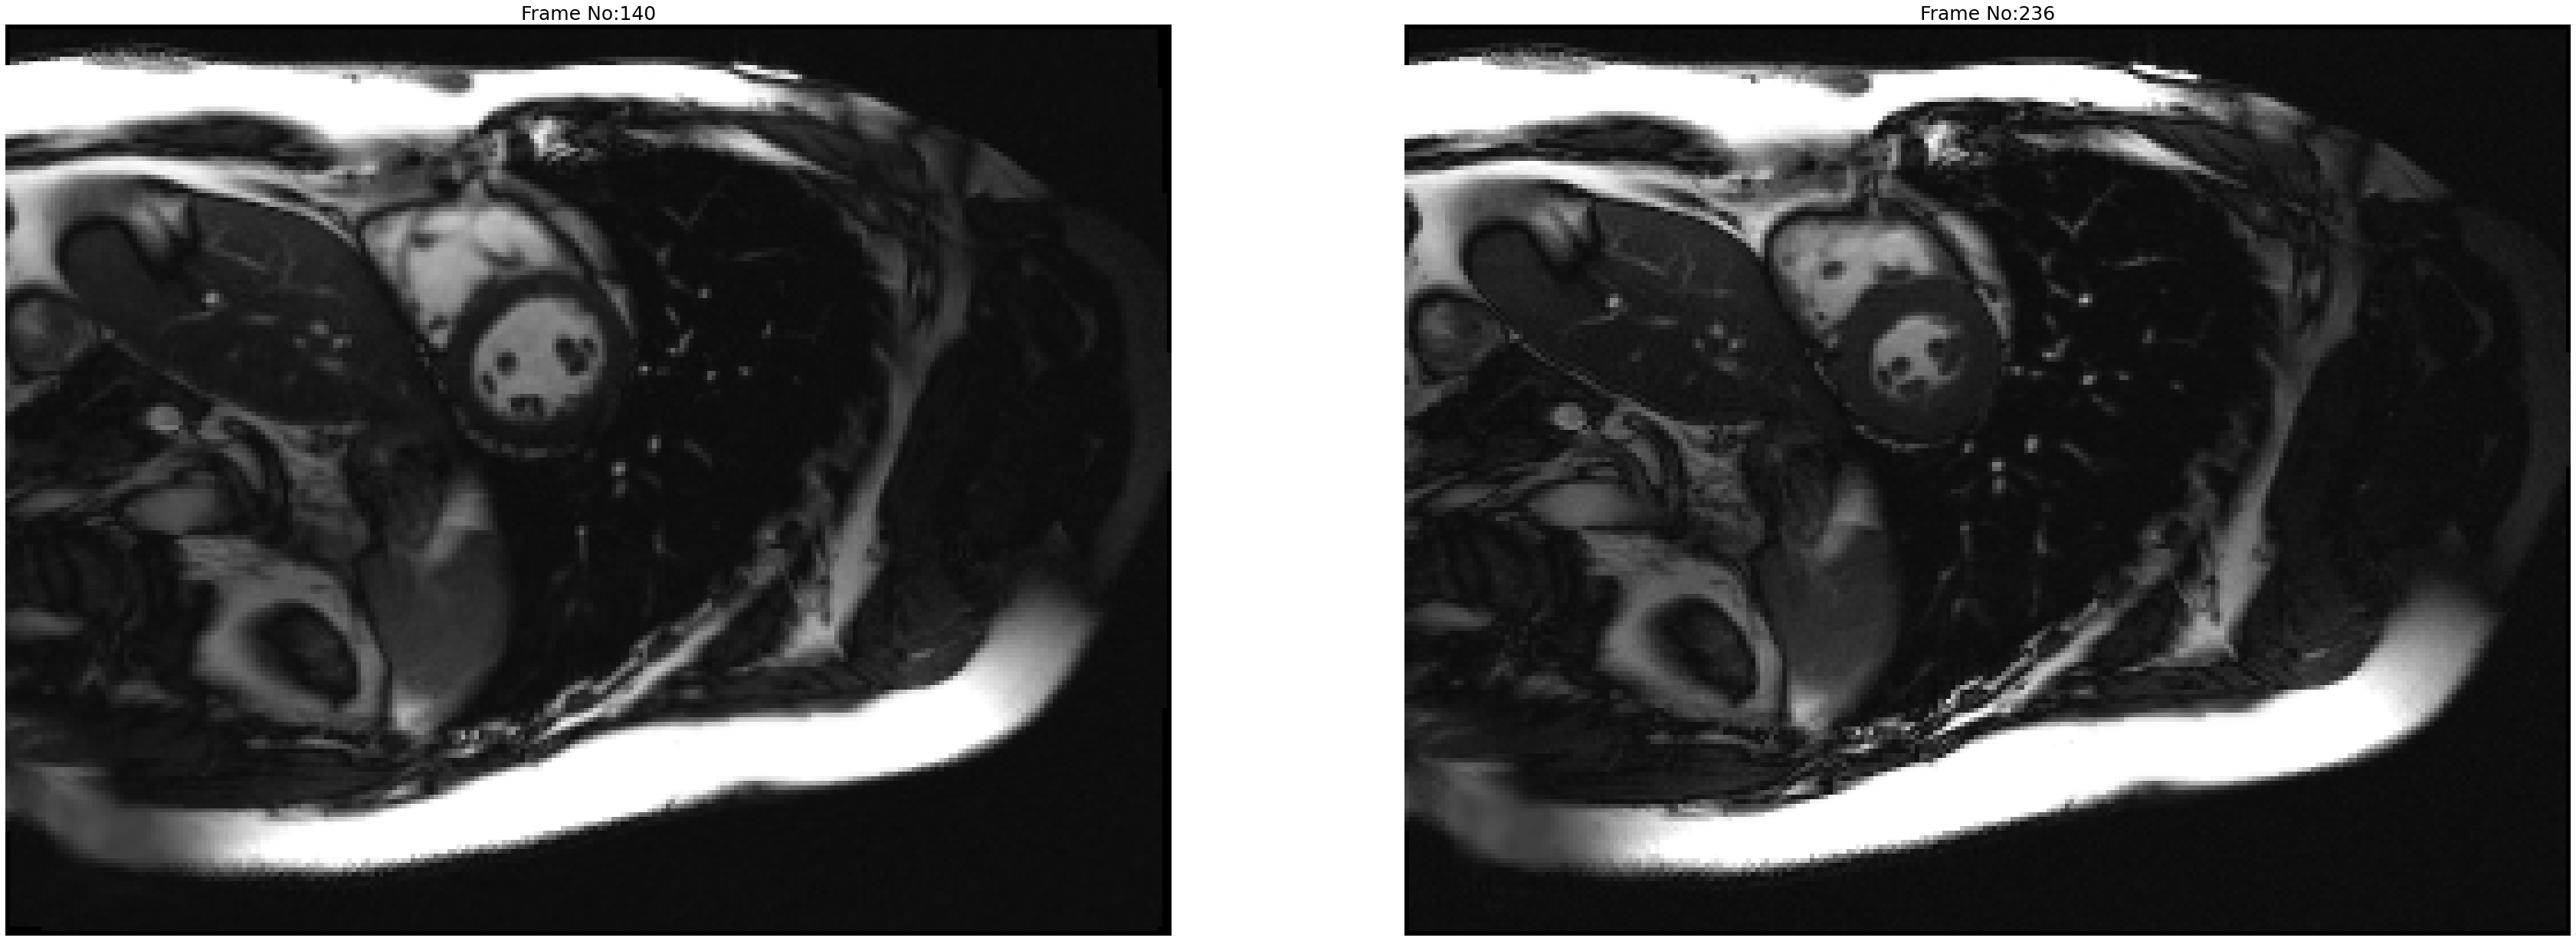

In [26]:
display_random_images(image,n=2)

In [27]:
# defines varibles
#Np: number of phase encodings
Np=image.shape[0]
#number of frequence encodings
Nf= image.shape[1]
#Nnav: Number of navigator lines
Nnav  = 4;

In [28]:
# convert image to tensor
image_tensor= torch.from_numpy(image)
# convert to k-space
Kraw=1/math.sqrt(Np*Nf)*torch.fft.fft2(image_tensor, dim=(1,0))
image_tensor_C= image_tensor.permute(1,0,2).reshape(Np*Nf,image.shape[-1])
Kraw_C=Kraw.permute(1,0,2).reshape(Np*Nf,image.shape[-1])

In [30]:
Kraw_C

tensor([[ 0.0186+0.0000j,  0.0186+0.0000j,  0.0186+0.0000j,  ...,
          0.0185+0.0000j,  0.0185+0.0000j,  0.0185+0.0000j],
        [ 0.0038+0.0013j,  0.0038+0.0013j,  0.0038+0.0013j,  ...,
          0.0038+0.0014j,  0.0038+0.0014j,  0.0038+0.0014j],
        [-0.0025-0.0010j, -0.0025-0.0010j, -0.0025-0.0010j,  ...,
         -0.0024-0.0011j, -0.0024-0.0011j, -0.0024-0.0011j],
        ...,
        [ 0.0023-0.0010j,  0.0023-0.0010j,  0.0023-0.0009j,  ...,
          0.0023-0.0009j,  0.0023-0.0009j,  0.0023-0.0009j],
        [ 0.0005+0.0032j,  0.0005+0.0032j,  0.0005+0.0032j,  ...,
          0.0004+0.0032j,  0.0004+0.0032j,  0.0004+0.0032j],
        [-0.0033+0.0031j, -0.0033+0.0031j, -0.0033+0.0031j,  ...,
         -0.0033+0.0031j, -0.0033+0.0031j, -0.0033+0.0032j]],
       dtype=torch.complex128)

In [9]:
#  form the k-t space sampling mask 
# Nsam number of sample in k space
Nsam = 32
#nav_ind: A vector containing the indices for navigator lines.
nav_ind = list(range(int(Np/2-Nnav/2),int(Np/2+Nnav/2)))


In [10]:
nav_ind

[98, 99, 100, 101]

## function to generate the sampling mask

In [11]:

def tem_sampling_generation(Np, Nfr, Nnav, Nsam):
    # Generate the temporal sampling mask
    # Inputs:
    # Np: number of phase encodings
    # Nfr: number of temporal frames
    # Nnav: number of phase encodings for navigator signal
    # Nsam: number of samples acquired at each k-space location
    #
    # Output:
    # temmask: temporal sampling mask

    temmask = torch.zeros((Np, Nfr))
    nav_ind = np.arange(Np // 2 - Nnav // 2, Np // 2 + Nnav // 2)

    for row in range(Np):
        if row in nav_ind:
            temmask[row, :] = torch.ones(Nfr)
        else:
            temp = torch.zeros(Nfr)
            ind = torch.randperm(Nfr)
            temp[ind[:Nsam]] = 1
            temmask[row, :] = temp

    temmask = temmask.bool()
    return temmask

In [12]:
temmask=tem_sampling_generation(Np,image.shape[-1],Nnav, Nsam)
temmask=torch.fft.fftshift(temmask,dim=0)
Nfr=256
Mask = temmask.repeat(Nf,1)
d_c=Kraw_C*Mask
d=d_c.T.flatten()
# get the indices of non-zero elements in x
nonzero_indices = torch.nonzero(d)
# extract the non-zero elements from x
d = d[nonzero_indices]

In [13]:
nav_location = torch.zeros((Np, 1),dtype=torch.bool)
nav_location[nav_ind] = 1

In [14]:
Navdata=Kraw[torch.fft.fftshift(nav_location).squeeze(1),:,:].permute(1,0,2).reshape(Nnav*Nf,image.shape[-1])
# order of the model
r=32
#perform SvD
u_np, s_np, vh_np = torch.svd(Navdata)
V_Tr=vh_np.T
V_Tr=V_Tr[:r,:]

In [15]:
# mu: regularization parameter
# beta: initial value of continuation parameter
beta = 1e3
mu   = 2.5e-6

In [16]:
#inital value of Us_r0
Us_r0=torch.zeros((Np*Nf,r))

In [17]:
V_Tr

tensor([[-0.0633-0.0000e+00j, -0.0633+9.7174e-06j, -0.0633+1.4203e-06j,
          ..., -0.0629-2.1409e-05j, -0.0629-2.4980e-05j,
         -0.0629-2.4864e-05j],
        [-0.0119-0.0000e+00j, -0.0144+4.1029e-03j, -0.0152+8.7133e-03j,
          ..., -0.0068+1.9064e-03j, -0.0058+9.6684e-04j,
         -0.0041-3.1558e-03j],
        [ 0.1087-0.0000e+00j,  0.1063+9.7147e-05j,  0.1017+4.9150e-04j,
          ...,  0.0530-1.1160e-03j,  0.0512-1.0701e-03j,
          0.0534-1.1523e-03j],
        ...,
        [-0.0740-0.0000e+00j,  0.0253+3.6557e-02j,  0.0023+3.4161e-02j,
          ...,  0.0299-3.5844e-02j,  0.0192-2.6058e-02j,
         -0.0268+3.2883e-03j],
        [-0.0709-0.0000e+00j, -0.0329+6.3735e-02j, -0.0108+1.6907e-02j,
          ..., -0.0112+1.5290e-02j, -0.0021-1.1129e-02j,
          0.0015-4.7192e-03j],
        [-0.0233-0.0000e+00j,  0.0501-3.7162e-02j,  0.0025-1.1238e-02j,
          ...,  0.0146-2.9937e-02j, -0.0032-3.5322e-02j,
          0.0150-2.0078e-02j]], dtype=torch.complex128)

## PS -Sparse reconstruction method

In [578]:
def ps_sparse_recon(d:torch.tensor,
                   M: torch.tensor,
                   Us_r: torch.tensor,
                   Vt_r: torch.tensor,
                   mu: float,
                   beta: float,
                   regularizer: str,
                   Np: int,
                   Nf: int,
                   Nfr: int):
    '''This code performs image reconstruction from highly undersampled data using
    joint partial separability (PS) and sparsity constraints
    
    Args:
        d: measured data undersampled  Size([1867776, 1])
        Mask: k-t space sampling mask Size([51200, 256])
        Us_r: initial value of Us_r Size([51200, 32])
        Vt_r: basis for the temporal subspace Size([32, 256])
        mu: regularization parameter 
        beta: initial value of continuation parameter
        regularizer: spa_reg for spatial sparsity regularization
        Np: number of phase encodings
        Nf: number of frequence encodings
        Nfr: number of temporal frames
    Return:
        Us_r: basis for the spatial subspace
    '''
    #tolerance for error
    tol = 1e-5
    #maximum number of iterations
    maxit = 200
    
    # size of temporal basis
    r= Us_r0.shape[-1]
    # get the rows and column index of the non-zero mask
    Rind,Cind=(torch.nonzero(Mask.T))[:,[1,0]][:,0],(torch.nonzero(Mask.T))[:,[1,0]][:,1]
    
    
    